# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang | Students: Elad Sofer & Raviv Ilani.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together.

To process and read the data, we use the popular `pandas` package for data analysis.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [ ]:
load_from_drive = True

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/Shareddrives/DNN_Elad_Raviv/YearPredictionMSD.txt'

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Mounted at /content/gdrive


FileNotFoundError: ignored

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [ ]:
df

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [ ]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [ ]:
df.head(20)

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [ ]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here:
#if we have the same artist showinmg in both the test set and the training set the system might be compromised in identifying
# a perticular artist's features instead of being as abstract as possible, risking in overfiting



### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [ ]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds


Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [ ]:
# Write your explanation here

# In order to validate our model which is based on training set, we need to represent the training & testing in the same way. assuming
# it came from the same X random variable.

# In theory, the main requirement for the optimized model to generalize is to have
# the data set comprised of i.i.d. samples, which implies that the empirical risk, means, variance converges to their
# true values as the training set size grows by the law of large numbers.

# In that manner, if we assume all of our data (testing & training sets) was generated from a certain X random variable
# Ideally, the training set and the testing set will have the same variation and means. (for a big enough testing and training sets)
# Although, in practice it's not the case. because the test set usually is much more smaller (so the law of large numbers do not apply, and anomalies can occur as well)
# so the means/variance of the testing set could be far from the true value.

# We can't use a different means to the validation set, otherwise it could lead that the validation came from a different random variable.
# and the main requirments for the optimized model won't occur.

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [ ]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
# We divide our train data into 3 sets validation set, training set and test set. the validation set
# target is to estimate the performance of our model in each iteration. we need the validation set
# in order to examine which hyper parameters are giving us the best model. this is why we track our model
# behaviour in each iteration. while tracking the performance, we will choose the best model upon it's performance, although
# it's performance is relying upon the validation set, so in case we encounter overfitting (upon the validation set) we want
# to test our NN upon a different dataset. and use it as a majorment to avoid overfitting. we want to distinguish between
# the dataset for choosing the hyper parameters and the dataset for testing the overall NN behaviour.
# if we use the dataset during the training, we will be bias to choose our model upon that set as well.
# so the final test won't be effective (because we can encounter overfitting upon the test set as well)


## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [ ]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by:
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [ ]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here
  return sigmoid(np.dot(w,np.transpose(X))+b)


In [ ]:
pred(np.zeros(90), 1, np.ones([5, 90]))

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [ ]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)
  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """

  # Your code goes here
  N= np.shape(X)[0]
  return (1/N)*np.matmul(np.transpose(X), y-t), (1/N)*(np.sum(y-t))



# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)


\begin{equation}
L = -t * log(t) -(1-y) * log(1-y) \end{equation}
\begin{equation} y = sigmoid(z) = \frac{1}{1-e^{-z}} \end{equation}
\begin{equation} z^i = ({\bf w}^T {\bf x^i} + b),
\end{equation}
\begin{equation}
\frac{dy}{dw_j} = \sigma({\bf w}^T {\bf x^i} + b)(1-\sigma({\bf w}^T {\bf x^i} + b))x_j = y(1-y)x_j
\end{equation}

\begin{equation}
\frac{dl}{dy} = \frac{-t}{y}+\frac{1-t}{1-y}
\end{equation}

$ \bigtriangledown_w L = \frac{1}{N} \sum_{i=1}^{N}\bigtriangledown_wl= \frac{1}{N} \sum_{i=1}^{N}\frac{\partial l}{\partial w} ==\frac{1}{N} \sum_{i=1}^{N} \frac{\partial l}{\partial y} \frac{\partial y}{\partial w} =\frac{1}{N} X^T(\frac{-t}{y}+\frac{1-t}{1-y})y(1-y) = \frac{1}{N}X^T(y-t)$

$ \bigtriangledown_b L = \frac{1}{N} \sum_{n=1}^{N}\bigtriangledown_bl= \frac{1}{N} \sum_{n=1}^{N}\frac{\partial l}{\partial b} =\frac{1}{N} \sum_{n=1}^{N} \frac{\partial l}{\partial y} \frac{\partial y}{\partial b} =\frac{1}{N} \sum_{n=1}^{N}(\frac{-t}{y}+\frac{1-t}{1-y})y(1-y) = \frac{1}{N} \sum_{n=1}^{N}(y-t) $


### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [ ]:
# Your code goes here
h = 10e-4
X=np.array([4])
t=np.array([3])
w=np.array([3])
b=np.array([8])

y=pred(w, b, X)
y_x_plus_h=pred(w, b+h, X)

dLdW, dLdB = derivative_cost(X, y, t)





r1 = dLdB
r2 = ((cross_entropy(t, y_x_plus_h) - cross_entropy(t, y))/h)[-1]
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [ ]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code

h = 10e-4
X=np.array([4])
t=np.array([3])
w=np.array([3])
b=np.array([8])

y=pred(w, b, X)
y_x_plus_h=pred(w+h, b, X)

dLdW, dLdB = derivative_cost(X, y, t)


r1 = dLdW
r2 = ((cross_entropy(t, y_x_plus_h) - cross_entropy(t, y))/h)[-1]
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent.
Complete the following code that will run stochastic: gradient descent training:

In [ ]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float

  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  global train_xs, val_ts, train_norm_xs, val_norm_xs, train_ts
  w = w0
  b = b0
  iter = 0
  loss_array_val = []
  VAL_LENGTH = len(val_ts)

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    # shuffle the training set
    reindex = np.random.permutation(len(train_xs))

    # features vector
    train_xs = train_xs[reindex]
    train_norm_xs = train_norm_xs[reindex]
    # year vector - labels
    train_ts = train_ts[reindex]

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs[i:(i + batch_size)]
      t = train_ts[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w, b, X)

      # update w and b
      dLdW, dLdB = derivative_cost(X, y, t )
      b = b - mu*dLdB
      w = w - mu*dLdW

      # increment the iteration count
      iter += 1

      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        val_cost = 0
        val_acc = 0
        y_val = pred(w, b, val_norm_xs)
        for i_t, i_y in zip(map(lambda x: x[0], val_ts), y_val):
          y_, t_ = np.array([i_y]), np.array([i_t])
          cost_i = cost(y_[0], t_[0])
          if not np.isnan(cost_i) and not np.isinf(cost_i):

            val_cost += cost_i/VAL_LENGTH

          val_acc += get_accuracy(y_, t_)/len(val_norm_xs)
        loss_array_val+=[val_cost]
        print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (
                iter, val_acc * 100, val_cost))

      if iter >= max_iters:
        x_axis = np.arange(10, max_iters + 10, 10)
        plt.plot(x_axis, loss_array_val, 'r-', label="loss val")
        #plt.plot(x_axis, loss_array_train, 'g-', label="loss train")
        plt.legend()
        plt.title('Validation set Loss vs Iteration mu={mu}'.format(mu=mu))
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        break;

      # Think what parameters you should return for further use

  return w, b


### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

In [ ]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here
mus= [0.01, 0.5, 100 ]
for mu in mus:
  run_gradient_descent(w0,b0, mu)







**Explain and discuss your results here:**



we will get the best results when the network's parameters converge to a global minima of cost fuction. when we use a too large learning rate the parameters might jump over minimum whithout ever converging to it resulting in a resulting in "overshooting". too small of a learning rate might take too long to converge and risiking getting stuck in a local minima without ever reaching the global one. this can be shown in the figures above where a small learning rate gives a a linear slow a steady convergong graph while the too large learning rate jumps all over.



### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

In [ ]:

def get_optimal_rand(w,b,size):
  mu = [np.random.uniform(0, 1) for i in range(size)]
  batch= [np.random.randint(1, len(train_xs)) for i in range(size)]

  val_acc_temp =0

  for i in range(1,size):
    print("mu:", mu[i], "batch size:", batch[i] )
    w , b = run_gradient_descent(w0, b0, mu[i], batch[i] , max_iters=100)
    y_val=pred(w,b,val_norm_xs)
    val_acc = get_accuracy(y_val,val_ts)
    if (val_acc_temp < val_acc) :
      val_acc_temp = val_acc
      w_opt, b_opt = w , b

  return w_opt, b_opt


In [ ]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

w_opt, b_opt = get_optimal_rand(w0,b0,100)


In [ ]:
#optimal b and w after runnig the program:

w_opt= [ 1.35127201e+00, -1.02483271e+00, -4.62664721e-01,  4.98761494e-01,
       -1.83756235e-01, -1.01668509e+00, -2.44870956e-01, -1.71661277e-01,
       -1.83500582e-01, -1.01121757e-01, -4.87551676e-01,  1.45309989e-01,
        3.46325967e-01,  1.58830071e-01, -1.11276385e-01,  1.79039040e-02,
       -3.76774395e-02,  2.24750243e-01,  1.04717143e-01, -1.66887331e-01,
       -1.06112210e-01,  4.49302646e-01,  7.33274469e-01,  3.47900808e-02,
       -2.14784138e-01,  8.45031104e-02,  2.01655373e-01,  3.88160789e-02,
       -4.31162072e-02, -1.77127620e-04, -1.50487152e-02, -6.03851996e-02,
       -8.33959250e-03, -3.20592670e-03,  9.11464889e-02, -1.55892428e-01,
       -8.98920542e-02,  9.82273371e-02,  4.44954214e-02, -5.75755562e-02,
       -9.78038715e-02, -5.18041810e-02,  1.24456419e-03, -7.55342563e-04,
        2.28864582e-02,  2.11193808e-01,  5.70056403e-03, -6.50813278e-02,
        7.62481244e-02, -2.46316410e-02,  1.81390432e-02, -2.57190110e-03,
        9.68082799e-02,  1.31798828e-03, -7.00420397e-02,  3.11951617e-02,
       -1.41470782e-01,  1.63484051e-01, -7.13530454e-02, -6.84557969e-02,
       -6.80627242e-02, -2.61846079e-02, -3.27865150e-01,  1.02505988e-01,
       -8.39863837e-02, -9.76252384e-03,  3.76187766e-02,  3.55112137e-02,
       -2.08128549e-02, -8.57730226e-02, -1.03894421e-01,  7.54514031e-02,
       -8.58458958e-02,  4.09614802e-02,  7.16216533e-02,  2.54177544e-02,
        1.20250047e-03, -1.41234470e-01, -4.96233772e-02,  3.69498001e-02,
       -9.39100397e-02,  6.42013465e-02,  7.55807980e-02, -3.57901797e-02,
        8.66354633e-02,  1.95073423e-03,  3.18231886e-02, -3.73210110e-01,
       -2.32549082e-02,  7.25987919e-02]

b_opt= 0.3119357591087439


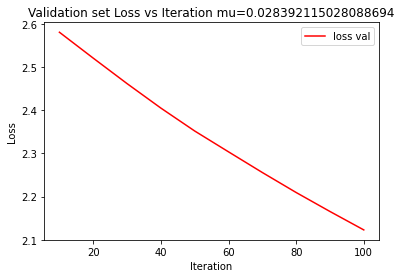


too small of a learning rate resulting in a liner graph
while good hyperparameters give us an exponantial decaying graph:
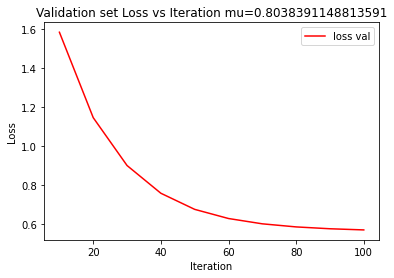

**Explain and discuss your results here:**
>optimal b and w were chosen by randomly choosing different learning rates and batch sizes. it seems that the 73% accuracy limit cannot be breached implying that maybe more layers are needed for better results.




### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [ ]:
# Write your code here
w=w_opt
b=b_opt
y_train=pred(w,b,train_norm_xs)
y_val=pred(w,b,val_norm_xs)
y_test=pred(w,b,test_norm_xs)
train_acc = get_accuracy(y_train,train_ts)
val_acc = get_accuracy(y_val,val_ts)
test_acc = get_accuracy(y_test,test_ts)
print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)



**Explain and discuss your results here:**

>  we can see the three are just about the same with a slight advantage to
the val_acc. obviously due to the fact that the optimal b and w were chosen by optimaizing the val_acc.
test a bit lower than the train due to the fact that the test was on unseen samples.
nonetheless we can see that our network has managed to get a good generalization of the data





### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [ ]:
import sklearn.linear_model

from sklearn.linear_model import LogisticRegression
model= LogisticRegression()
model.fit(train_norm_xs,train_ts)
train_acc = model.score(train_norm_xs,train_ts)
val_acc = model.score(val_norm_xs,val_ts)
test_acc = model.score(test_norm_xs,test_ts)
print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)



print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
